In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp

## Goal: estimate parameters in interacting model

I have the functional forms of the n-point correlation functions.  These contain all the useful information about the fields I want to study.  There are unconstrained parameters in the model that need to be filled in before I can make useful predictions.

Once the parameters are determined, I can make estimates addressing questions like:  "given the current prices, volatilities, and volumes in the market for AAPL and for a broader market index...
- how likely is it that AAPL is above/below a certain price by next week? 
- how likely is it that volatility will increase/decrease (and by how much) by next week?"

#### steps: 
- define exact 2-point function to 1-loop precision in $x_i$ space
- define data $x_i$ by aggregating weekly data;  $x = $[t, price, volatility]
- using squared 2-point propagator amplitudes as probability densities, sample posterior $P(m_\phi, m_\psi, \lambda_{\phi\psi} | \{p_i\})$
- use posterior distributions to estimate $ m_\phi$, $m_\psi$, $\lambda_{\phi\psi}$

#### exact 2-point propagator to 1-loop precision in $x_i$ space

In [1244]:
from scipy.special import hankel1, k1

def propagator_2pt_position_space(x1, x2, other_field_value, m_squared, lambda_phi_psi):
    """
    x1 - list with length d, values of position vector with d components; [x1_t, x1_1, ... x1_n]
    x2 - list with length d, values of position vector with d components; [x2_t, x2_1, ... x2_n]
    other_field_value - tuple, (buyers(p), sellers(p))
    m_squared - float, free parameter
    lambda_phi_psi - float, free parameter
    
    return float, propagator value (precise to 1-loop)
    """
    s = -1 * (x2[0] - x1[0]) ** 2 + (np.array(x2[1:]) - np.array(x1[1:])).dot(np.array(x2[1:]) - np.array(x1[1:]))
#     print('s = ', s)
    m = np.real(np.sqrt(m_squared + lambda_phi_psi * other_field_value[0] * other_field_value[1] + 0j))

    # timelike
    if s > 0:
        return m / (8. * np.pi * np.sqrt(s)) * hankel1(1, m * np.sqrt(s))
    
    # spacelike
    if s < 0:
        return -1j * m / (4. * np.pi ** 2 * np.sqrt(-1 * s)) * k1(m * np.sqrt(-s))
    
    else:
        return np.inf



#### data transformation
need initial/final observations (separated in time and price/volatility), with price, volatility, and volume for each observation

In [1949]:
def make_data(path_to_data):
    '''
    str path_to_data: path to prepared file with raw, daily observations of bid, ask, total volume for AAPL and SPY

    return: df with initial/final data vectors for both AAPL and SPY, and field values at the initial time
    
            note:
            - initial corresponds to each week in daily data, final is 1, 2, and 3 weeks later.
            - volumes are in units of 1e7
                
    '''
    
    data_raw = pd.read_csv(path_to_data).rename(columns={'Unnamed: 0': 'date'}).replace(0, np.nan)
    data_raw['week'] = data_raw.date.astype('datetime64').dt.to_period('W')
    
    # group by week to get approx volatilities for each week
    data = data_raw.groupby('week').agg(['mean', 'std']).dropna()

    result = pd.DataFrame()
    volume_factor = 1e7 # normalize volume to units of 10 millions
    aapl_price_factor = 1
    spy_price_factor = 1
    for initial_week in data.iterrows():
        for j in range(1, 3):
            try:
                final_week = data.loc[initial_week[0] + j]

                x1 = [0, initial_week[1]['bid_aapl']['mean']/ aapl_price_factor, initial_week[1]['bid_aapl']['std']]  # t = 0
                x2 = [j, final_week['ask_aapl']['mean']/ aapl_price_factor, final_week['ask_aapl']['std']]  # t = j (in weeks)

                y1 = [0, initial_week[1]['bid_spy']['mean']/ spy_price_factor, initial_week[1]['bid_spy']['std']]  # t = 0
                y2 = [j, final_week['ask_spy']['mean']/ spy_price_factor, final_week['ask_spy']['std']]  # t = j (in weeks)

                phi_x = (initial_week[1]['totalVolume_aapl']['mean'] / volume_factor, initial_week[1]['totalVolume_aapl']['mean'] / volume_factor)
                psi_x = (initial_week[1]['totalVolume_spy']['mean'] / volume_factor, initial_week[1]['totalVolume_spy']['mean'] / volume_factor)

                result = result.append({'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'phi_x': phi_x, 'psi_x': psi_x}, ignore_index=True)

            except KeyError:
                continue
    return result

#### (log) likelihood of observations given values for $ m_\phi$, $m_\psi$, $\lambda_{\phi\psi}$

In [1263]:
def likelihood(data, m_phi_squared, m_psi_squared, lambda_phi_psi):

    phi_propagators = data.apply(lambda row: propagator_2pt_position_space(row['x1'], row['x2'], row['psi_x'], m_phi_squared, lambda_phi_psi), axis=1)
    psi_propagators = data.apply(lambda row: propagator_2pt_position_space(row['x1'], row['x2'], row['phi_x'], m_psi_squared, lambda_phi_psi), axis=1)
    
    # form "amplitude" for combined propagators
    amplitude = np.abs(phi_propagators * psi_propagators)
    
    # transform likelihood to log likelihood
    amplitude = np.log(amplitude)

    return amplitude.sum()

In [1950]:
df = make_data('aapl_spy_2019_2020.csv')

In [1969]:
t0 = time.time()
posterior = {'m_phi_squared': [], 'm_psi_squared': [], 'lambda_phi_psi': []}
current = [3.2011, 66.4858, 1.9644]  # old: 8.2234, 70.6460, 1.5947
log_likelihood_current = likelihood(df, *current)

step_width_m_phi = .001
step_width_m_psi = .001
step_width_lambda_phi_psi = .0001

samples = 100000
r_accept = 0.05
num_accepted = 0
step_taken = []
r_list = []

for i in range(samples):
    
    #  generate proposal
    proposed = sp.random.normal(current, [step_width_m_phi, step_width_m_psi, step_width_lambda_phi_psi])
    
    # constrain m_psi so m_phi and lambda_phi_psi chains converge
#     proposed[0] = -22.434
#     proposed[1] = 55.005
#     proposed[2] = 2.402 # 3.1365

    #  compute likelihood of current step and proposal step
    log_likelihood_proposed = likelihood(df, *proposed)

    #  compute prior of current and proposal -- with flat priors, this cancels

    #  acceptance ratio
    r = np.exp(log_likelihood_proposed - log_likelihood_current)
    r_list.append(r)
    
    # take step
#     if sp.random.random() < min(1, r):
#     if r > 1:
    if (r > 1) or (sp.random.random() < r_accept):
        current = proposed
        log_likelihood_current = log_likelihood_proposed
        posterior['m_phi_squared'].append(current[0])
        posterior['m_psi_squared'].append(current[1])
        posterior['lambda_phi_psi'].append(current[2])
        num_accepted += 1
        step_taken.append(1)
    else:
        step_taken.append(0)


print(f'time to run: {time.time() - t0}')
print(f'accept rate: {num_accepted / float(samples)}')

time to run: 1402.9131689071655
accept rate: 0.17149


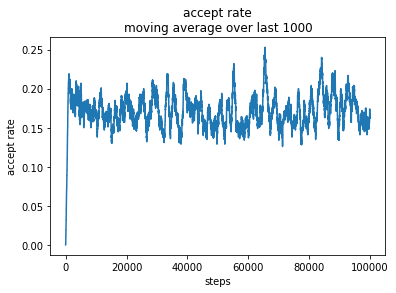

In [1997]:
fig, ax = plt.subplots()
n = 1000
ax.plot(np.arange(len(step_taken)), np.convolve(step_taken, np.ones(n))[:len(step_taken)] / n)
plt.title('accept rate\nmoving average over last 1000')
plt.xlabel('steps')
plt.ylabel('accept rate')
plt.show()

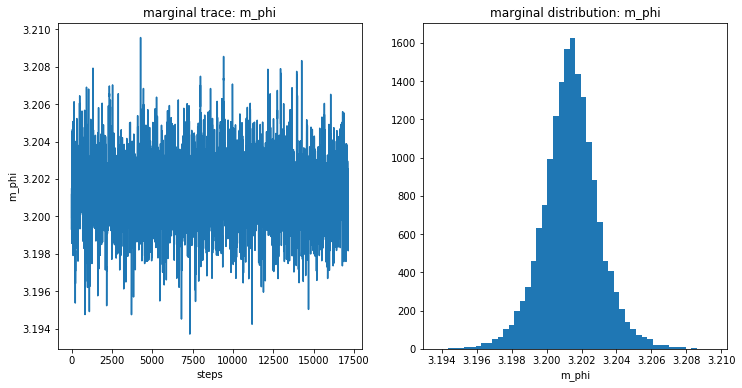

In [1984]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(posterior['m_phi_squared'])
ax[1].hist(posterior['m_phi_squared'], bins=50)
ax[0].set_title('marginal trace: m_phi')
ax[0].set_xlabel('steps')
ax[0].set_ylabel('m_phi')
ax[1].set_title('marginal distribution: m_phi')
ax[1].set_xlabel('m_phi')
plt.show()

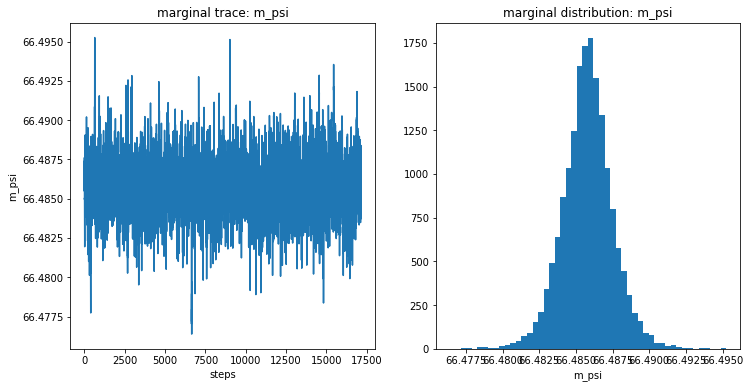

In [1986]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(posterior['m_psi_squared'])
ax[1].hist(posterior['m_psi_squared'], bins=50)
ax[0].set_title('marginal trace: m_psi')
ax[0].set_xlabel('steps')
ax[0].set_ylabel('m_psi')
ax[1].set_title('marginal distribution: m_psi')
ax[1].set_xlabel('m_psi')
plt.show()

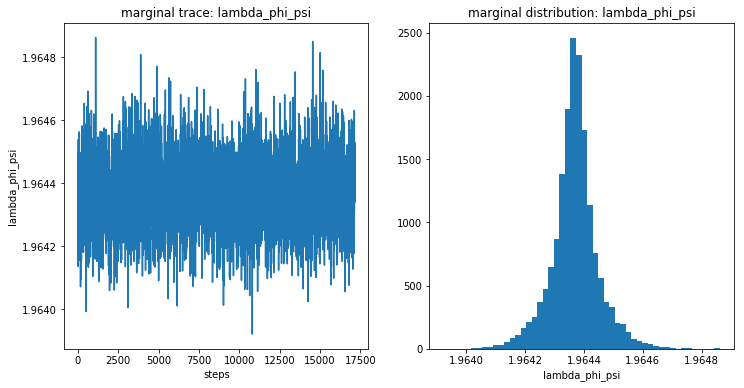

In [1987]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(posterior['lambda_phi_psi'])
ax[1].hist(posterior['lambda_phi_psi'], bins=50)
ax[0].set_title('marginal trace: lambda_phi_psi')
ax[0].set_xlabel('steps')
ax[0].set_ylabel('lambda_phi_psi')
ax[1].set_title('marginal distribution: lambda_phi_psi')
ax[1].set_xlabel('lambda_phi_psi')
plt.show()

In [1995]:
%matplotlib inline

<IPython.core.display.Javascript object>


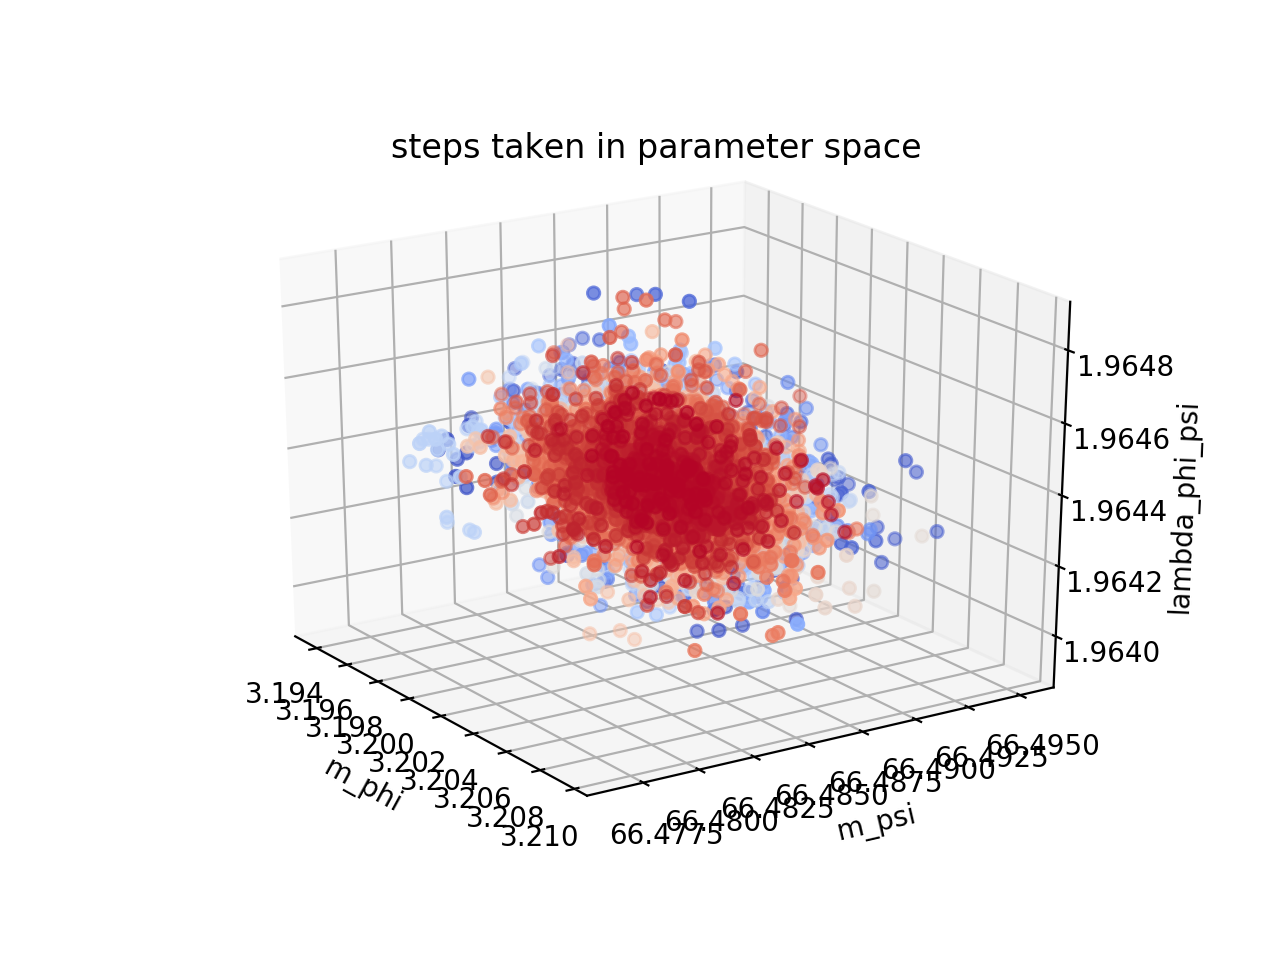

In [1994]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(posterior['m_phi_squared'], posterior['m_psi_squared'], posterior['lambda_phi_psi'], c=range(len(posterior['m_phi_squared'])), cmap='coolwarm')
plt.title('steps taken in parameter space')
ax.set_xlabel('m_phi')
ax.set_ylabel('m_psi')
ax.set_zlabel('lambda_phi_psi')
plt.show()

## using this procedure, MCMC chains converged
maximum likelihood estimates for parameters are:
- $ m_\phi$: 3.202
- $m_\psi$: 66.486
- $\lambda_{\phi\psi}$: 1.9644

### OLD: first attempt to fit $ m_\phi$, $m_\psi$, $\lambda_{\phi\psi}$

#### steps: 
- define exact 2-point propagator to 1-loop precision in $p$ space
- define $S-$matrix elements using exact propagator
- define data in terms of $p_i$ using differences between weeks of $x_i$ data 
- using $S-$matrix elements as probability densities, sample posterior $P(m_\phi, m_\psi, \lambda_{\phi\psi} | \{p_i\})$
- use posterior distributions to estimate $ m_\phi$, $m_\psi$, $\lambda_{\phi\psi}$

In [3]:
def exact_2pt_propagator(p, other_field_value, m_squared, lambda_phi_psi):
    """
    p - list with length d, values of momentum vector with d components
    other_field_value - tuple, (buyers(p), sellers(p))
    m_squared - float, free parameter
    lambda_phi_psi - float, free parameter
    
    return float, propagator value (precise to 1-loop)
    """
    if isinstance(p, list):
        p_squared = np.array(p).dot(np.array(p))
        
    else:
        p_squared = p.dot(p)

    other_field_magnitude = other_field_value[0] * other_field_value[1]
    
    return 1. / (p_squared + m_squared + lambda_phi_psi * other_field_magnitude)

In [4]:
def phi_psi_2pt_smatrix_element(final_p_phi, final_p_psi, initial_p_phi, initial_p_psi,
                                m_phi_squared, m_psi_squared, lambda_phi_psi, phi, psi):

    final_p_phi_squared = np.array(final_p_phi).dot(np.array(final_p_phi))
    final_p_psi_squared = np.array(final_p_psi).dot(np.array(final_p_psi))
    initial_p_phi_squared = np.array(initial_p_phi).dot(np.array(initial_p_phi))
    initial_p_psi_squared = np.array(initial_p_psi).dot(np.array(initial_p_psi))

    
    return 1 / (2 * np.pi) ** 6 * (final_p_phi_squared - m_phi_squared) * (final_p_psi_squared - m_psi_squared) * (initial_p_phi_squared - m_phi_squared) * (initial_p_psi_squared - m_psi_squared) * exact_2pt_propagator(np.array(final_p_phi) - np.array(initial_p_phi), psi, m_phi_squared, lambda_phi_psi) * exact_2pt_propagator(np.array(final_p_psi) - np.array(initial_p_psi), phi, m_psi_squared, lambda_phi_psi)
     

In [301]:
def likelihood(data, m_phi_squared, m_psi_squared, lambda_phi_psi):
    
    result = 0
    
    final_phi_price = None
    final_phi_vol = None
    final_p_phi = None
    final_psi_price = None
    final_psi_vol = None
    final_p_psi = None
    final_volume_aapl = None
    final_volume_spy = None
    
    # for each pair of final/initial momenta: 
    for initial_p in data.dropna().iterrows():
        initial_p = initial_p[1]

        initial_phi_price = initial_p['p_aapl_bid'] * initial_p['p_aapl_ask'] / 2.
        initial_phi_vol = initial_p['p_aapl_bid_vol'] * initial_p['p_aapl_ask_vol'] / 2.
        initial_p_phi = [initial_phi_price, initial_phi_vol]

        initial_psi_price = initial_p['p_spy_bid'] * initial_p['p_spy_ask'] / 2.
        initial_psi_vol = initial_p['p_spy_bid_vol'] * initial_p['p_spy_ask_vol'] / 2.
        initial_p_psi = [initial_psi_price, initial_psi_vol]

        initial_volume_aapl = initial_p['totalVolume_aapl']
        initial_volume_spy = initial_p['totalVolume_spy']
        
        phi = (initial_volume_aapl, final_volume_aapl)
        psi = (initial_volume_spy, final_volume_spy)

        args = [final_p_phi, final_p_psi, initial_p_phi, initial_p_psi,
                m_phi_squared, m_psi_squared, lambda_phi_psi, phi, psi]

        if final_phi_price is not None:
        # ... calculate the L(parameters|observation)
            result += np.log(phi_psi_2pt_smatrix_element(*args) ** 2)
        
        final_phi_price = initial_phi_price
        final_phi_vol = initial_phi_vol
        final_p_phi = initial_p_phi
        
        final_psi_price = initial_psi_price
        final_psi_vol = initial_psi_vol
        final_p_psi = initial_p_psi
        
        final_volume_aapl = initial_volume_aapl
        final_volume_spy = initial_volume_spy
        
            
    return result

        

### setup data for sampling

p = volume * (last - first) / elapsed time

elapsed time in weeks

In [146]:
data_raw = pd.read_csv('aapl_spy_2019_2020.csv').rename(columns={'Unnamed: 0': 'date'}).replace(0, np.nan)

data_raw['week'] = data_raw.date.astype('datetime64').dt.to_period('W')

data_weekly = data_raw.groupby('week').agg({'bid_aapl': ['std', 'mean', 'first', 'last'],
                          'ask_aapl': ['std', 'mean', 'first', 'last'],
                          'totalVolume_aapl': 'sum',
                          'bid_spy': ['std', 'mean', 'first', 'last'],
                          'ask_spy': ['std', 'mean', 'first', 'last'],
                          'totalVolume_spy': 'sum'})


data_weekly[('bid_aapl', 'p_bid')] = (data_weekly['bid_aapl']['last'] - data_weekly['bid_aapl']['first']) * data_weekly['totalVolume_aapl']['sum']
data_weekly[('ask_aapl', 'p_ask')] = (data_weekly['ask_aapl']['last'] - data_weekly['ask_aapl']['first']) * data_weekly['totalVolume_aapl']['sum']
data_weekly[('bid_spy', 'p_bid')] = (data_weekly['bid_spy']['last'] - data_weekly['bid_spy']['first']) * data_weekly['totalVolume_spy']['sum']
data_weekly[('ask_spy', 'p_ask')] = (data_weekly['ask_spy']['last'] - data_weekly['ask_spy']['first']) * data_weekly['totalVolume_spy']['sum']

data = data_weekly[[('bid_aapl', 'p_bid'), ('bid_spy', 'p_bid'), ('ask_aapl', 'p_ask'), ('ask_spy', 'p_ask'), ('bid_aapl', 'std'), ('bid_spy', 'std'), ('ask_aapl', 'std'), ('ask_spy', 'std'), ('totalVolume_aapl', 'sum'), ('totalVolume_spy', 'sum')]].reset_index()
data.columns = ['week', 'p_aapl_bid', 'p_spy_bid', 'p_aapl_ask', 'p_spy_ask', 'p_aapl_bid_vol', 'p_spy_bid_vol', 'p_aapl_ask_vol', 'p_spy_ask_vol', 'totalVolume_aapl', 'totalVolume_spy']

data[['p_aapl_bid_vol', 'p_spy_bid_vol', 'p_aapl_ask_vol', 'p_spy_ask_vol']] = data[['p_aapl_bid_vol', 'p_spy_bid_vol', 'p_aapl_ask_vol', 'p_spy_ask_vol']].diff()


In [243]:
normalize = [1e8, 1e8, 1e8, 1e8, 1, 1, 1, 1, 1e8, 1e8]
data.head().set_index('week') / normalize

,p_aapl_bid,p_spy_bid,p_aapl_ask,p_spy_ask,p_aapl_bid_vol,p_spy_bid_vol,p_aapl_ask_vol,p_spy_ask_vol,totalVolume_aapl,totalVolume_spy
week,,,,,,,,,,
2019-02-04/2019-02-10,-2.039364,-4.737956,-1.985380,-4.661041,NaN,NaN,NaN,NaN,0.599813,1.538298
2019-02-11/2019-02-17,0.524518,4.853647,0.492591,4.804120,-1.590990,-0.098995,-1.576848,-0.084853,0.456103,1.650900
2019-02-18/2019-02-24,-0.463890,-1.449247,-0.450884,-1.477388,-0.056569,-1.350574,-0.028284,-1.315219,0.433542,1.407036
2019-02-25/2019-03-03,0.641180,0.050342,0.631240,0.025171,0.155563,-0.700036,0.162635,-0.728320,0.497039,1.258548
2019-03-04/2019-03-10,-1.580769,-8.238339,-1.574237,-8.238339,0.321891,1.771947,0.324281,1.786450,0.653210,2.288427


### sampling

In [261]:
import time

In [542]:
t0 = time.time()
normalize = [1e8, 1e8, 1e8, 1e8, 1, 1, 1, 1, 1e8, 1e8] # make sure likelihoods don't blow up
current = [0, 0, 0] # [m_phi_squared, m_psi_squared, lambda_phi_psi] 5e4, -2.46e5, -1.5e4
posterior = {'m_phi_squared': [], 'm_psi_squared': [], 'lambda_phi_psi': []}
r_acceptance = .3
log_likelihood_current = likelihood(data.set_index('week') / normalize, *current)
samples = 300000

for i in range(samples):

#     step_width_m_phi = 100.0
#     step_width_m_psi = 500.0
#     lambda_phi_psi = 250.0
    step_width_m_phi = 10.0
    step_width_m_psi = 10.0
    lambda_phi_psi = 10.0

    #  generate proposal
    proposed = sp.random.normal(current, [step_width_m_phi, step_width_m_psi, lambda_phi_psi])

    #  compute likelihood of current step and proposal step
    log_likelihood_proposed = likelihood(data.set_index('week') / normalize, *proposed)

    #  compute prior of current and proposal -- with flat priors, this cancels

    #  acceptance ratio
    r = np.exp(log_likelihood_proposed - log_likelihood_current)

    # take step
#     if (r > 1.0) | (sp.random.random() > (1 - r_acceptance)):
    if sp.random.random() < min(1, r):
        current = proposed
        log_likelihood_current = log_likelihood_proposed
        posterior['m_phi_squared'].append(current[0])
        posterior['m_psi_squared'].append(current[1])
        posterior['lambda_phi_psi'].append(current[2])

print(time.time() - t0)

2560.013872861862


## using this procedure, none of the MCMC chains converged